In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
# import repackage
# repackage.add('../../')
# repackage.add('../')

In [3]:
# Suite for Analysis - Overview

# script needs to:
# load 1-5 variables from multiple files
# run some calculation and concatenate together
# make some plots

In [4]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

In [5]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [6]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

making dx/dy
mapping u/v to u/v rho


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [7]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_MKPA/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_MKPA = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

/jobfs/134824176.gadi-pbs/ipykernel_622504/81831706.py:96: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = cs.collections[0].get_paths()[0]


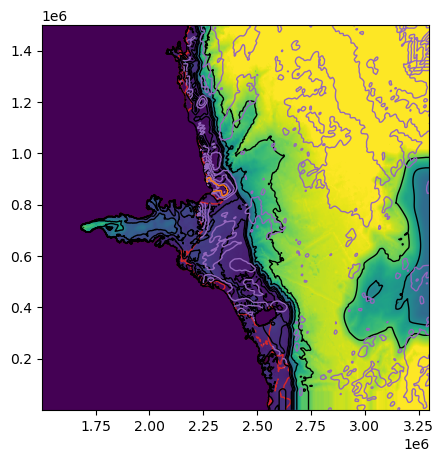

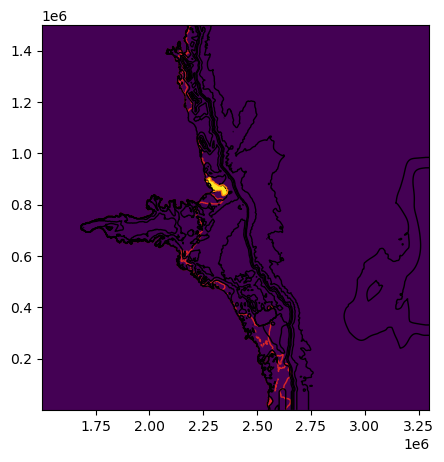

In [8]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r



# make grid masks


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_openocean'] = grd.mask_rho*(grd.mask_zice==0)
grd['mask_openoceanNaN'] = grd.mask_openocean.where(grd.mask_openocean)
grd['mask_rhoNaN'] = grd.mask_rho.where(grd.mask_rho)
grd['mask_ziceNaN'] = grd.mask_zice.where(grd.mask_zice)

# amery mask

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])

mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])
grd['mask_zice_roi'] = grd.mask_zice*mask_roi
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

# polyna-center masks

ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


plotting=False
if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(ds.h*ds.mask_rho)
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    co2 = plt.contour(ds.h*ds.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
    plt.contour(swflux.mean(dim='swf_time')*ds.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)
    plt.plot(394,438,'x')
    plt.plot(364,393,'x')
    plt.plot(391,461,'x')
    plt.colorbar()
    plt.axis((300,500,250,500))

mask_burton_center = np.zeros_like(grd.lon_rho)
mask_burton_center[461:461+4,391:391+4]=1

mask_capedarnley_center = np.zeros_like(grd.lon_rho)
mask_capedarnley_center[437:437+4,393:393+4]=1

mask_mackenzie_center = np.zeros_like(grd.lon_rho)
mask_mackenzie_center[392:392+4,363:363+4]=1

mask_fasticetongue = np.zeros_like(grd.lon_rho)
mask_fasticetongue[400:425,367:425]=1
mask_fasticetongue = mask_fasticetongue*grd.mask_zice

if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(mask_fasticetongue*ds.zice,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    plt.axis((300,500,250,500))


# make polynya-area masks


ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


mask_capedarnley_tempo = np.zeros_like(grd.lon_rho)
mask_capedarnley_tempo[410:460,380:450]=1

plt.figure(figsize=(5,5))
plt.pcolormesh(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho)
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)

cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

# paths = cs.get_paths()[0].to_polygons()
# plt.plot(paths[1][:,0],paths[1][:,1])
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
mask_capedarnley_tempo2 = inpolygon(grd.x_rho.values, grd.y_rho.values, x, y)


plt.figure(figsize=(5,5))
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_capedarnley_tempo2*grd.mask_openocean)

mask_capedarnley = mask_capedarnley_tempo2*grd.mask_openocean
grd['mask_capedarnley'] = mask_capedarnley


# make CD shelf area mask
mask_CDshelf = (grd.h<1000) & (grd.y_rho<1.1e6) & (grd.y_rho>.85e6) & (grd.mask_rho==1) | ((grd.h>1000) & (grd.x_rho<2.3e6) & (grd.y_rho<1.1e6) & (grd.y_rho>.85e6) & (grd.mask_rho==1))
grd['mask_CDshelf'] = mask_CDshelf


# define weighting parameters

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"



In [40]:
ds_CTRL.s_rho[0]

<xarray.DataArray 's_rho' ()> Size: 8B
array(-0.98387097)
Coordinates:
    s_rho    float64 8B -0.9839
Attributes:
    standard_name:  ocean_s_coordinate_g2
    long_name:      S-coordinate at RHO-points
    valid_min:      -1.0
    valid_max:      0.0
    positive:       up
    formula_terms:  s: s_rho C: Cs_r eta: zeta depth: h depth_c: hc

In [32]:
print(' make dayofyear means ')
print(' have to first fix the time coordinate to ignore the leap year. sigh.')

No_of_years=5
dayofyear = np.concatenate([np.array((356,361)),np.tile(np.arange(1,365,5),No_of_years-1),np.arange(1,365-10,5)])
dayofyear_da = xr.DataArray(dayofyear,[('day',dayofyear)])

ds_CTRL['day']=dayofyear_da
ds_CTRL['my_doy']=ds_CTRL.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['salt_doy']=ds_CTRL.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['temp_doy']=ds_CTRL.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

ds_MKPA['day']=dayofyear_da
ds_MKPA['salt_doy']=ds_MKPA.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['my_doy']=ds_MKPA.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['temp_doy']=ds_MKPA.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


 make dayofyear means 
 have to first fix the time coordinate to ignore the leap year. sigh.


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, re

In [ ]:
print('make climatology')


In [34]:
ds_CTRL

<xarray.Dataset> Size: 234GB
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 248B -0.9839 -0.9516 ... -0.01613
  * s_w                (s_w) float64 256B -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 5MB 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 5MB 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 5MB dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u                (eta_rho, xi_u) float64 5MB dask.array<chunksize=(750, 899), meta=np.ndarray>
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 5MB 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 5MB -76.25 -76.23 ... -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 173MB dask.array<chunksize=(32, 750, 900), meta=np.ndarray>
    z_rho0             (s_rho, eta_rho, xi_rho) float64 167MB dask.array<chunksize=(31, 750, 900), meta=np.ndarray>
  * day                (day) int64 3kB 356 361 1 6 11 16 ... 331 336 341 346 351
  * dayofyear          (dayofyear) int64 584B 1 6 11 16 21 ... 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/107)
    ntimes             int32 4B ...
    ndtfast            int32 4B ...
    dt                 float64 8B ...
    dtfast             float64 8B ...
    dstart             datetime64[ns] 8B ...
    nHIS               int32 4B ...
    ...                 ...
    dA                 (eta_rho, xi_rho) float64 5MB dask.array<chunksize=(750, 900), meta=np.ndarray>
    u_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 31GB dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 31GB dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    my_doy             (dayofyear, eta_rho, xi_rho) float64 394MB dask.array<chunksize=(1, 750, 900), meta=np.ndarray>
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 6GB dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 6GB dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [35]:
!ls ../data/proc


AIS05_outflow_pos.nc		  amery_DIAG_salt_rate_int.nc
AIS2_outflow_pos.nc		  amery_DIAG_salt_vadv_dz.nc
amery_DIAG_dz.nc		  amery_DIAG_salt_vadv_int_1yr.nc
amery_DIAG_salt_hadv_dz.nc	  amery_DIAG_salt_vadv_int.nc
amery_DIAG_salt_hadv_int_1yr.nc   amery_DIAG_salt_vdiff_dz.nc
amery_DIAG_salt_hadv_int.nc	  amery_DIAG_salt_vdiff_int_1yr.nc
amery_DIAG_salt_hdiff_dz.nc	  amery_DIAG_salt_vdiff_int.nc
amery_DIAG_salt_hdiff_int_1yr.nc  amery_extract_meltmon.nc
amery_DIAG_salt_hdiff_int.nc	  CTRL_outflow_pos.nc
amery_DIAG_salt_rate_dz.nc	  MKPA_outflow_pos.nc
amery_DIAG_salt_rate_int_1yr.nc


In [36]:
ds_tmp = ds_CTRL
out_file = '../data/proc/'+'amery_clima_CTRL_extract.nc'
# Select specific variables
variables = ["temp_doy", "salt_doy", "my_doy", "z_rho0","dayofyear"]
ds_subset = ds_tmp[variables]

# Define region (e.g., bounding box for lat/lon)
xi_range = slice(50,440) 
eta_range = slice(250,425)

# Subset region
ds_subset = ds_subset.sel(xi_rho=xi_range, eta_rho=eta_range)

# Save or return the new dataset
ds_subset.to_netcdf(out_file)  # Save to file if needed

print('saving \n'+str(ds_subset)+'\n to \n'+out_file)

TypeError: can only concatenate str (not "Array") to str

In [37]:
ds_tmp = ds_MKPA
out_file = '../data/proc/'+'amery_clima_MKPA_extract.nc'
# Select specific variables
variables = ["temp_doy", "salt_doy", "my_doy", "z_rho0","dayofyear"]
ds_subset = ds_tmp[variables]

# Define region (e.g., bounding box for lat/lon)
xi_range = slice(50,440) 
eta_range = slice(250,425)

# Subset region
ds_subset = ds_subset.sel(xi_rho=xi_range, eta_rho=eta_range)

# Save or return the new dataset
ds_subset.to_netcdf(out_file)  # Save to file if needed

print('saving \n'+str(ds_subset)+'\n to \n'+out_file)

TypeError: can only concatenate str (not "Array") to str

In [38]:
print('saving \n'+str(ds_subset)+'\n to \n'+out_file)

saving 
<xarray.Dataset> Size: 1GB
Dimensions:    (dayofyear: 73, s_rho: 31, eta_rho: 175, xi_rho: 390)
Coordinates:
    z_rho0     (s_rho, eta_rho, xi_rho) float64 17MB dask.array<chunksize=(31, 175, 390), meta=np.ndarray>
  * dayofyear  (dayofyear) int64 584B 1 6 11 16 21 26 ... 341 346 351 356 361
  * s_rho      (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    x_rho      (eta_rho, xi_rho) float64 546kB 1.601e+06 1.603e+06 ... 2.379e+06
    y_rho      (eta_rho, xi_rho) float64 546kB 5.01e+05 5.01e+05 ... 8.49e+05
    lon_rho    (eta_rho, xi_rho) float64 546kB 72.62 72.64 72.66 ... 70.34 70.36
    lat_rho    (eta_rho, xi_rho) float64 546kB -74.65 -74.63 ... -67.07 -67.05
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp_doy   (dayofyear, s_rho, eta_rho, xi_rho) float32 618MB dask.array<chunksize=(1, 31, 175, 390), meta=np.ndarray>
    salt_doy   (dayofyear, s_rho, eta_rho, xi_rho) float32 618MB dask.array<chunksize=(1, 31, 175, 390), meta=np.ndarra

In [11]:
ds_m

<xarray.DataArray 'my_doy' (dayofyear: 73, eta_rho: 750, xi_rho: 900)> Size: 394MB
dask.array<transpose, shape=(73, 750, 900), dtype=float64, chunksize=(1, 750, 900), chunktype=numpy.ndarray>
Coordinates:
    x_rho      (eta_rho, xi_rho) float64 5MB 1.501e+06 1.503e+06 ... 3.299e+06
    y_rho      (eta_rho, xi_rho) float64 5MB 1e+03 1e+03 ... 1.499e+06 1.499e+06
    lon_rho    (eta_rho, xi_rho) float64 5MB 89.96 89.96 89.96 ... 65.55 65.56
    lat_rho    (eta_rho, xi_rho) float64 5MB -76.25 -76.23 ... -57.53 -57.51
  * dayofyear  (dayofyear) int64 584B 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: eta_rho, xi_rho

In [12]:
import pandas as pd
day_to_month = pd.date_range("2001-01-01", "2001-12-31").to_series().dt.month

month_lookup = day_to_month.iloc[ds_CTRL.dayofyear - 1].values

print(month_lookup)

ds_m = ds_m.assign_coords(month=("dayofyear", month_lookup))

# Group by month and calculate the mean for each month
ds_m_mon = ds_m.groupby("month").mean()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


[ 1  1  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4
  5  5  5  5  5  5  5  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8
  8  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12
 12]


In [13]:
ds_m

<xarray.DataArray 'my_doy' (dayofyear: 73, eta_rho: 750, xi_rho: 900)> Size: 394MB
dask.array<transpose, shape=(73, 750, 900), dtype=float64, chunksize=(1, 750, 900), chunktype=numpy.ndarray>
Coordinates:
    x_rho      (eta_rho, xi_rho) float64 5MB 1.501e+06 1.503e+06 ... 3.299e+06
    y_rho      (eta_rho, xi_rho) float64 5MB 1e+03 1e+03 ... 1.499e+06 1.499e+06
    lon_rho    (eta_rho, xi_rho) float64 5MB 89.96 89.96 89.96 ... 65.55 65.56
    lat_rho    (eta_rho, xi_rho) float64 5MB -76.25 -76.23 ... -57.53 -57.51
  * dayofyear  (dayofyear) int64 584B 1 6 11 16 21 26 ... 341 346 351 356 361
    month      (dayofyear) int32 292B 1 1 1 1 1 1 1 2 ... 11 12 12 12 12 12 12
Dimensions without coordinates: eta_rho, xi_rho

(1600000.0, 2250000.0, 600000.0, 800000.0)

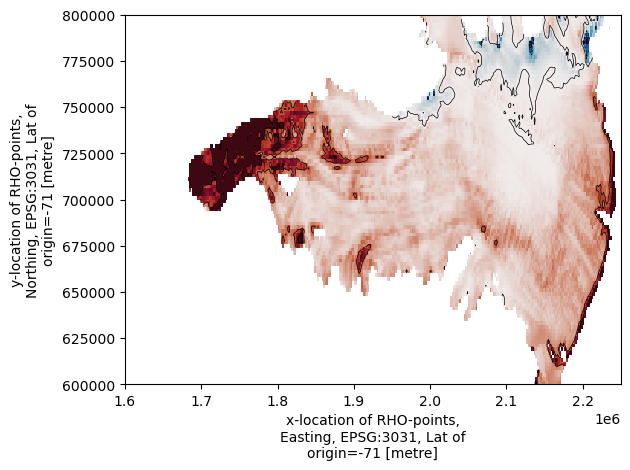

In [14]:

winter_period_doy=slice(49,62)
summer_period_doy=slice(12,25)


im1 = (ds_CTRL.mask_rho*(ds_CTRL.mask_ziceNaN)*ds_CTRL.my_doy.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot(x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds_CTRL.mask_rho*(ds_CTRL.mask_ziceNaN)*ds_CTRL.my_doy.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot.contour(x='x_rho',y='y_rho',colors='k',linewidths=.5,
                                                                                                         levels=np.arange(-4,6,2))

plt.axis((1.6e6,2.25e6,.6e6,.8e6))

(1600000.0, 2250000.0, 600000.0, 800000.0)

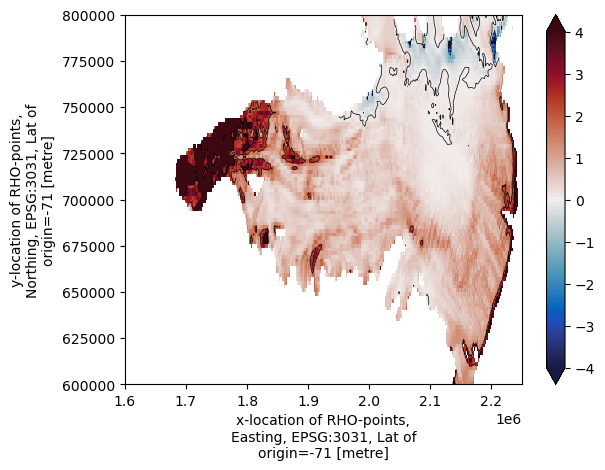

In [15]:

im1 = (ds_CTRL.mask_rho*(ds_CTRL.mask_ziceNaN)*ds_m.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot(x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=True,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds_CTRL.mask_rho*(ds_CTRL.mask_ziceNaN)*ds_m.isel(dayofyear=summer_period_doy).mean(dim='dayofyear')).plot.contour(x='x_rho',y='y_rho',colors='k',linewidths=.5,
                                                                                                         levels=np.arange(-4,6,2))

plt.axis((1.6e6,2.25e6,.6e6,.8e6))

(1600000.0, 2250000.0, 600000.0, 800000.0)

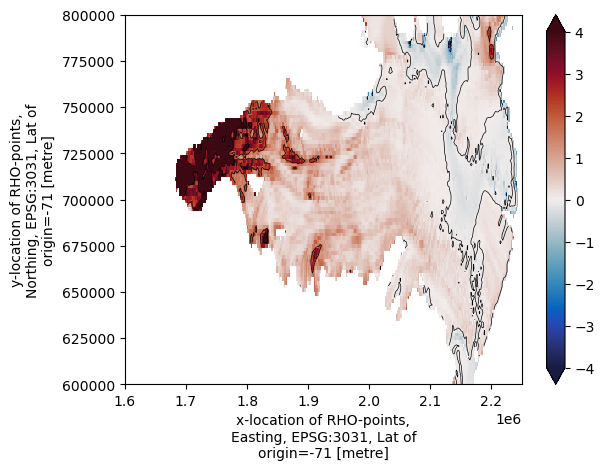

In [16]:
(ds_m*grd.mask_ziceNaN).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(x='x_rho',y='y_rho',vmin=-4,vmax=4,cmap='cmo.balance')
(ds_m*grd.mask_ziceNaN).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(x='x_rho',y='y_rho',colors='k',linewidths=.5,levels=np.arange(-4,6,2))

plt.axis((1.6e6,2.25e6,.6e6,.8e6))

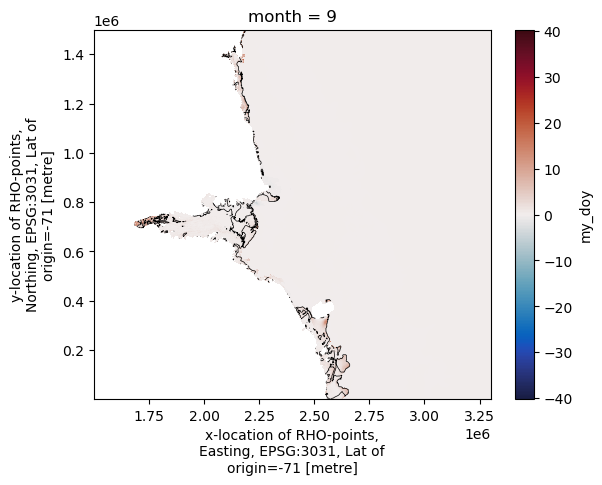

In [17]:
(ds_m_mon).sel(month=3).plot(x='x_rho',y='y_rho',cmap='cmo.balance')

(ds_m_mon).sel(month=9).plot.contour(x='x_rho',y='y_rho',colors='k',linewidths=.5,levels=np.arange(-4,6,2))




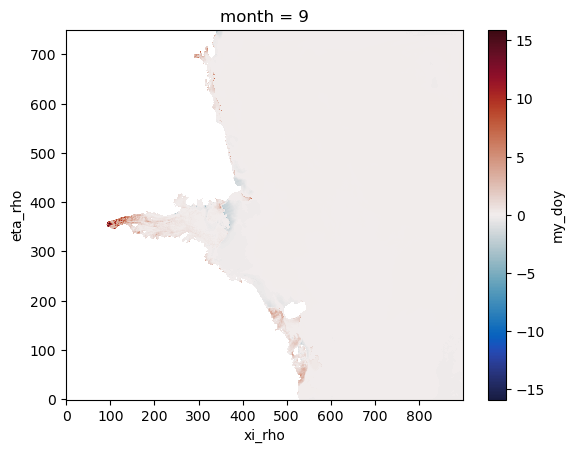

In [18]:
(ds_m_mon).sel(month=9).plot(cmap='cmo.balance')


In [19]:
# mask by ice
ds_m_mon = ds_m_mon*grd.mask_ziceNaN

In [20]:
# chop everything outside of x/y box
ds_m_mon = ds_m_mon.sel(xi_rho=slice(50,440)).sel(eta_rho=slice(250,425))

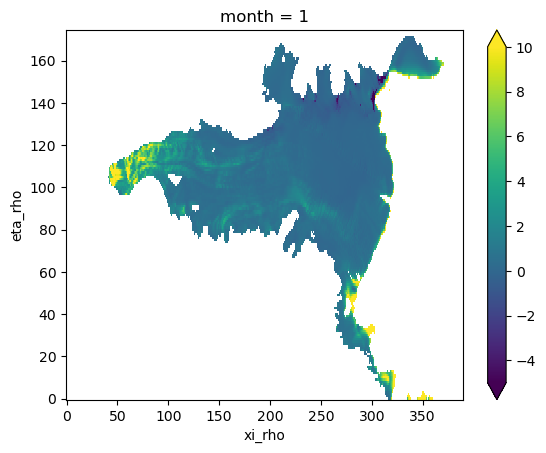

In [21]:
ds_m_mon.isel(month=0).plot(vmin=-5,vmax=10)

In [22]:
ds_m_mon.attrs['units']='meter year-1'
ds_m_mon.attrs['negative_value']='re/freezing'
ds_m_mon.attrs['positive_value']='melting'
ds_m_mon.attrs['_FillValue']='NaN'
ds_m_mon.attrs['author']='David Gwyther'
ds_m_mon.attrs['contact']='david.gwyther@gmail.com'


In [23]:
ds_m_mon

<xarray.DataArray (month: 12, eta_rho: 175, xi_rho: 390)> Size: 7MB
dask.array<getitem, shape=(12, 175, 390), dtype=float64, chunksize=(1, 175, 390), chunktype=numpy.ndarray>
Coordinates:
    x_rho    (eta_rho, xi_rho) float64 546kB 1.601e+06 1.603e+06 ... 2.379e+06
    y_rho    (eta_rho, xi_rho) float64 546kB 5.01e+05 5.01e+05 ... 8.49e+05
    lon_rho  (eta_rho, xi_rho) float64 546kB 72.62 72.64 72.66 ... 70.34 70.36
    lat_rho  (eta_rho, xi_rho) float64 546kB -74.65 -74.63 ... -67.07 -67.05
  * month    (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    units:           meter year-1
    negative_value:  re/freezing
    positive_value:  melting
    _FillValue:      NaN
    author:          David Gwyther
    contact:         david.gwyther@gmail.com

In [24]:
ds_m_mon.to_netcdf('../data/proc/amery_extract_meltmon.nc')